In [1]:
from crabnet.crabnet_ import CrabNet
import re
from pymatgen.core import Composition
from matplotlib import pyplot as plt
import numpy as np
# %matplotlib notebook
from ipywidgets import interactive, FloatLogSlider, jsdlink
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import xarray as xr
from crabnet.utils.data import groupby_formula
import requests
import json
import nest_asyncio
import pandas as pd
nest_asyncio.apply()
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'font.family': "Arial"}) 

sns.set_palette("coolwarm",8)

## Retrieving solar cell data from the nomad archive

In [2]:
import getpass
password = getpass.getpass()

In [3]:
response = requests.get(
    'https://nomad-lab.eu/prod/v1/staging/api/v1/auth/token', params=dict(username='pepe_marquez', password=password))
token = response.json()['access_token']

Runs a query to the NOMAD archive to retrieve all the solar cell entries contaiing a bandgap value. It will possibly take like 20 minutes to get all the data from the server. Note that there are more than 42k solar cell entries in the archive.

In [15]:
base_url = 'https://nomad-lab.eu/prod/v1/staging/api/v1/'

bandgaps =[]
vocs = []
jscs = []
ffs = []
pces = []
formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {#"results.material.material_name:any": ["perovskite"],
              "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"],
              "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 20,
                   'page_after_value': page_after_value}
  }).json()

  #if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    else:
      bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

In [16]:
len(bandgaps)

640

Let's store the formulas and bandgaps in a pandas dataframe

In [39]:
df = pd.DataFrame({'formula': formulas, 'bandgap': bandgaps})


NameError: name 'formulas' is not defined

In [ ]:
df.to_csv('perovskite_bandgap.csv', index=False)

Import perovskite_bandgap.csv as a pandas DataFrame. This df contains the results of the API query above, which typically needs several minutes to be processed. 

In [4]:
df = pd.read_csv('perovskite_bandgap.csv')
df

,formula,bandgap
0,H6Pb1C1I3N1,2.563483e-19
1,H6Pb1C1I3N1,2.563483e-19
2,H6Pb1C1I3N1,2.563483e-19
3,H6Pb1C1I3N1,2.531439e-19
4,H6Pb1C1I3N1,2.563483e-19
...,...,...
31155,H6Pb1C1I3N1,2.563483e-19
31156,H6Pb1C1I3N1,2.563483e-19
31157,H6Pb1C1I3N1,2.531439e-19
31158,H6Pb1C1I3N1,2.563483e-19


In [5]:
# Change the values of bandgap from units of Joule to electronvolt
df['bandgap'] = df['bandgap'] * 6.24150974e18
df.head()

,formula,bandgap
0,H6Pb1C1I3N1,1.60
1,H6Pb1C1I3N1,1.60
2,H6Pb1C1I3N1,1.60
3,H6Pb1C1I3N1,1.58
4,H6Pb1C1I3N1,1.60


The distribution of the chemical diveristy of the dataset can be viewed in the perodioc table of the NOMAD entries explorer. The down right corner of every element shows the number of entries (solar cells) that contain in the absorber a given element. It becomes obvius that the dtaa set is imbalance with the majority of the entries being *Pb* based, containing *C*, *N* anf *H* (hybrid perovskites) and mostly halide compounds, with most of the entries having *I* and/or *Br*. 

![Periodic Table](nomad_periodic_table_perovskite_database.png)

There are many repeated formulas and bandgap values in the dataframe. We will use `group_by_formula` from crabnet utilities to end up with unique formula bandgap pairs. To do so we will average the value for a given formula

In [6]:
# rename the column 'bandgap' to 'target'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df_grouped_formula = groupby_formula(df, how='mean')
df_grouped_formula.head()

,formula,index,target
0,Ag1Bi1I4,"(9724,)",1.86
1,Ag1Bi2I7,"(3735,)",1.86
2,Ag2Bi1I5,"(18295,)",1.86
3,Ag38Bi750I2375,"(20894,)",1.86
4,Ag3Bi1I6,"(23211,)",1.86


In [7]:
df_grouped_formula

,formula,index,target
0,Ag1Bi1I4,"(9724,)",1.860
1,Ag1Bi2I7,"(3735,)",1.860
2,Ag2Bi1I5,"(18295,)",1.860
3,Ag38Bi750I2375,"(20894,)",1.860
4,Ag3Bi1I6,"(23211,)",1.860
...,...,...,...
855,Sn7H60Pb3C10I30N10,"(23551,)",1.170
856,Sn9H29C17I28N30,"(27088,)",1.410
857,Sr1H120Pb19C20I60N20,"(16958,)",1.632
858,Sr1H30Pb4C5I15N5,"(23333,)",1.628


Let's split this dataframe into a tran_df, a val_df and a test_df

In [8]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
train_df, val_df, test_df = \
              np.split(df_grouped_formula.sample(frac=1, random_state=42), 
                       [int(.8*len(df_grouped_formula)), int(.9*len(df_grouped_formula))])
# train_df.head(), val_df.head(), test_df.head()

## Building our CrabNet model and fitting with our train dataframe `train_df` and validating with `val_df`

In [30]:
# cb_eg_1 = CrabNet(mat_prop="bandgap", model_name='Perovskite_eg_1')
# cb_eg_1.load_network(model_data=r'Perovskite_eg_1.pth')


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


AssertionError: 

It took 20 minutes to run the cell bellow.


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 688/688 [00:00<00:00, 84505.13formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 86/86 [00:00<00:00, 86088.34formulae/s]


loading data with up to 8 elements in the formula
stepping every 60 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.204 val mae: 0.167


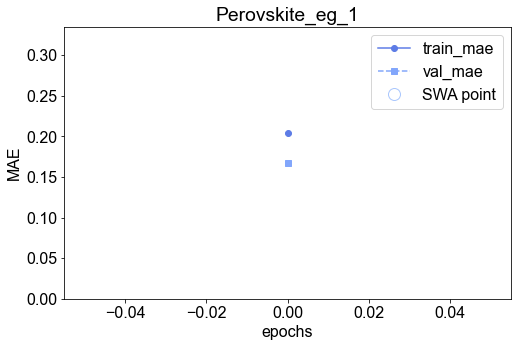

Epoch: 19/300 --- train mae: 0.0864 val mae: 0.1


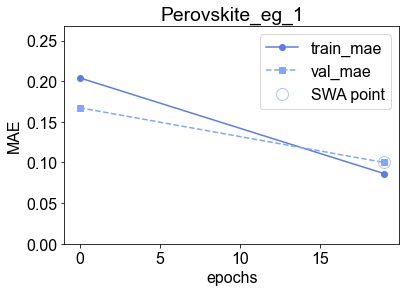

Epoch: 39/300 --- train mae: 0.0415 val mae: 0.075


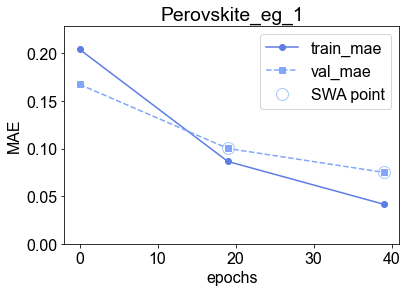

Epoch: 59/300 --- train mae: 0.0292 val mae: 0.0666


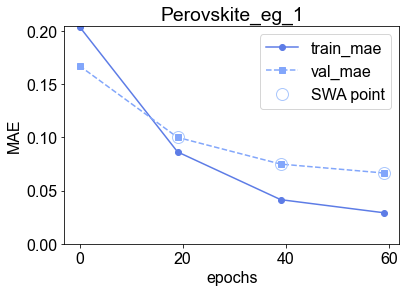

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0235 val mae: 0.0686


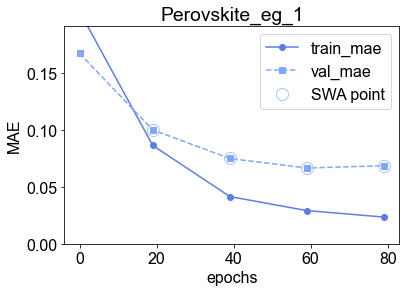

Epoch: 99/300 --- train mae: 0.0179 val mae: 0.0664


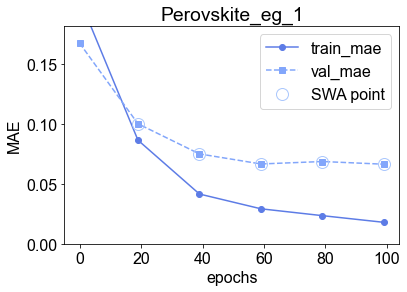

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0156 val mae: 0.0681


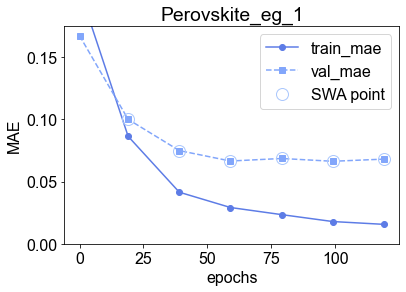

Epoch: 139/300 --- train mae: 0.014 val mae: 0.0664


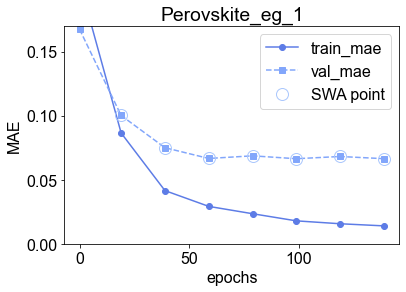

Epoch: 159/300 --- train mae: 0.0134 val mae: 0.0645


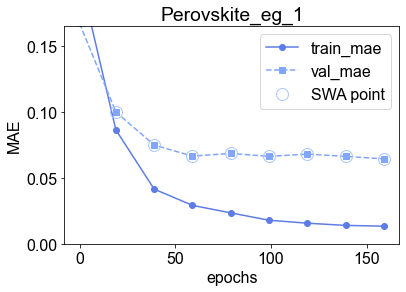

Epoch: 179/300 --- train mae: 0.0118 val mae: 0.0645


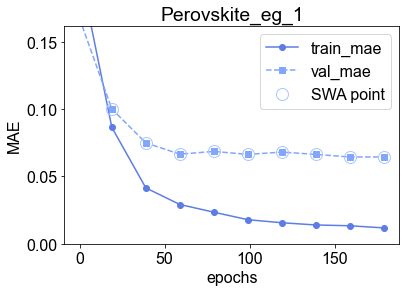

Epoch: 199/300 --- train mae: 0.0112 val mae: 0.0592


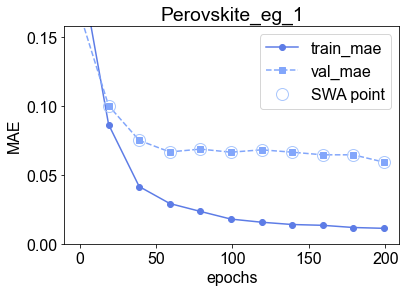

Epoch: 219/300 --- train mae: 0.0105 val mae: 0.0582


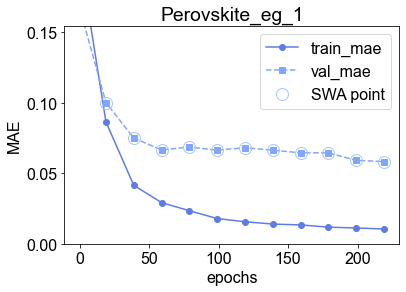

Epoch: 239/300 --- train mae: 0.00991 val mae: 0.0587


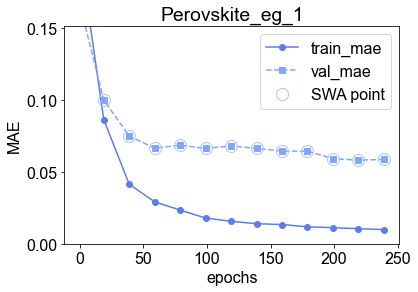

Epoch: 259/300 --- train mae: 0.0103 val mae: 0.0592


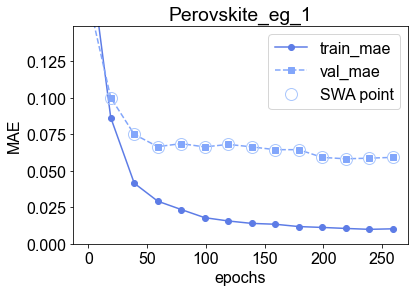

Epoch: 279/300 --- train mae: 0.00977 val mae: 0.0553


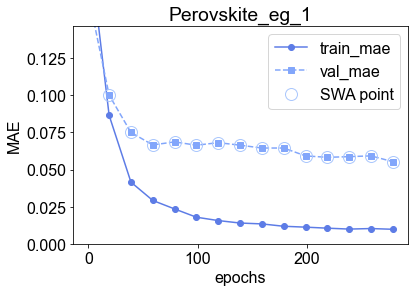

Epoch 299 failed to improve.
Discarded: 3/3 weight updates
Epoch: 299/300 --- train mae: 0.00898 val mae: 0.0582


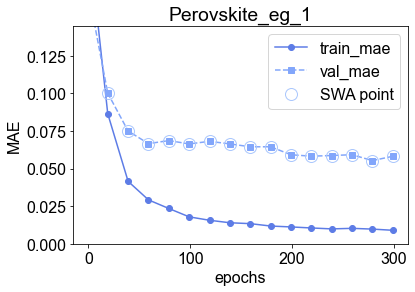

Discarded: 3/3weight updates, early-stopping now
Saving network (Perovskite_eg_1) to models\trained_models\Perovskite_eg_1.pth


In [10]:
cb_eg_1 = CrabNet(mat_prop="bandgap", model_name='Perovskite_eg_1', elem_prop='mat2vec', learningcurve=False)
cb_eg_1.fit(train_df, val_df)

Generating EDM: 100%|██████████| 688/688 [00:00<00:00, 66406.19formulae/s]


loading data with up to 8 elements in the formula


### Checking how the model performs with val data and test data `test_df`. 

Lets evaluate now the model in the train data, validation data and the test data.  
Let's start by importing some utilities from crabnet and sklearn.

In [11]:
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Generating EDM: 100%|██████████| 688/688 [00:00<00:00, 109248.17formulae/s]


loading data with up to 8 elements in the formula


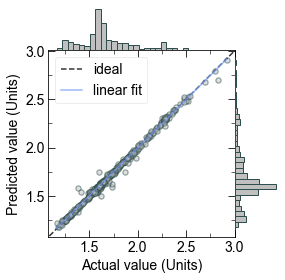

R2 score: 0.9950214812602542
MSE: 0.000404015277209653
MAE: 0.009799302782082216 eV


In [12]:
# Train data
train_df_zeros = pd.DataFrame(({"formula": train_df['formula'], "target": [0.0]*len(train_df['formula'])}))
train_df_predicted, train_df_predicted_sigma = cb_eg_1.predict(train_df_zeros, return_uncertainty=True)

act_pred(train_df['target'], train_df_predicted)
r2 = r2_score(train_df['target'], train_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(train_df['target'], train_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(train_df['target'], train_df_predicted)
print(f'MAE: {mae} eV')

Generating EDM: 100%|██████████| 86/86 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


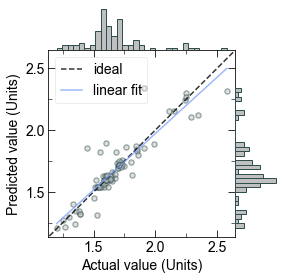

R2 score: 0.829594788833613
MSE: 0.010257591178010261
MAE: 0.05550914943836619 eV


In [13]:
# Validation data
val_df_zeros = pd.DataFrame(({"formula": val_df['formula'], "target": [0.0]*len(val_df['formula'])}))
val_df_predicted, val_df_predicted_sigma = cb_eg_1.predict(val_df_zeros, return_uncertainty=True)

act_pred(val_df['target'], val_df_predicted)
r2 = r2_score(val_df['target'], val_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(val_df['target'], val_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(val_df['target'], val_df_predicted)
print(f'MAE: {mae} eV')

Generating EDM: 100%|██████████| 86/86 [00:00<00:00, 5122.34formulae/s]


loading data with up to 8 elements in the formula


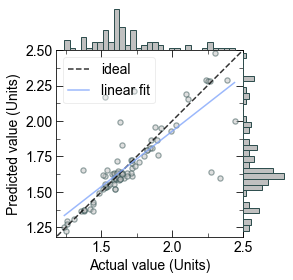

R2 score: 0.6355629348802752
MSE: 0.026118840343689345
MAE: 0.07943260222008672 eV


In [127]:
# Test data

test_df_zeros = pd.DataFrame(({"formula": test_df['formula'], "target": [0.0]*len(test_df['formula'])}))
test_df_predicted, test_df_predicted_sigma = cb_eg_1.predict(test_df_zeros, return_uncertainty=True)


act_pred(test_df['target'], test_df_predicted)

r2 = r2_score(test_df['target'], test_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(test_df['target'], test_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(test_df['target'], test_df_predicted)
print(f'MAE: {mae} eV')

In [29]:
test_df['predicted_bandgap'] = test_df_predicted
test_df['target_vs_predicted'] = abs(test_df['predicted_bandgap']-test_df['target'])
# test_df['rms_target_vs_predicted'] = ((test_df['predicted_bandgap'] - test_df['target']) ** 2) ** .5
test_df.sort_values(by=['target_vs_predicted'], ascending=False).head(40)

,formula,index,target,predicted_bandgap,target_vs_predicted,rms_target_vs_predicted
600,H41Pb1C4I4N1,"(4514, 14233)",2.335000,1.595622,0.739378,0.739378
130,Cs1H50Pb10C10Br30N209,"(25878,)",2.277000,1.639064,0.637936,0.637936
702,H777Pb20C40I9Br51N423,"(2126, 3078, 4521, 11591, 18741, 25454)",1.530000,2.166179,0.636179,0.636179
681,H71Pb4C7I13N2,"(11300,)",1.730000,2.208325,0.478325,0.478325
466,H16Pb1C6I4N2,"(29506,)",2.440000,1.997241,0.442759,0.442759
343,Cs5H3816Pb100C200I249Br251N2179,"(1236, 1899, 7079, 13792, 16045)",1.632000,1.990246,0.358245,0.358245
166,Cs1Sn1I2Br1,"(8505,)",1.370000,1.653651,0.283651,0.283651
661,H61Pb5C17I16N3,"(1915, 2071, 3065, 4022, 4456, 5771, 6010, 108...",1.643684,1.827978,0.184294,0.184294
782,Sn1H6C1N1Cl3,"(5709, 9692, 10928, 11841, 12376, 22516, 23042)",2.304286,2.482388,0.178102,0.178102
243,Cs30H120Pb40C80I91Br39N20,"(10569,)",1.900000,1.761499,0.138501,0.138501


## Let's do now some prediction for halide perovskite compositions.

Based on the trained model we predict now the bandgap for the ${CsPb(I_{1-x},Br_{x})_{3}}$ solid solution 

Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49908.42formulae/s]


loading data with up to 8 elements in the formula


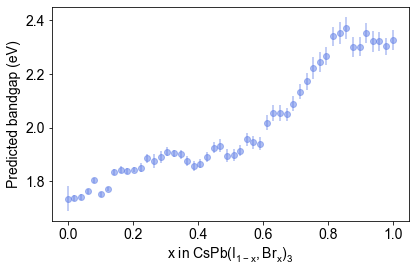

In [31]:
import numpy as np
X_comp = np.linspace(0, 1, 50)
complist = [f'CsPbI{3*(1-x)}Br{3*x}' for x in X_comp]
val_df = pd.DataFrame(({"formula": complist, "target": [0.0]*len(complist)}))
prediction, prediction_sigma = cb_eg_1.predict(val_df, return_uncertainty=True)
#plt.scatter(X_comp, prediction, alpha=0.5)
plt.errorbar(X_comp, prediction, yerr=prediction_sigma, fmt="o", alpha=0.5)
plt.ylabel("Predicted bandgap (eV)")
plt.xlabel("x in $\mathregular{CsPb(I_{1-x},Br_{x})_{3}}$" )
plt.tight_layout()
plt.show()

But we can extend this to more complex compositional spaces where electronic based calculations would become very expensive. For example for: 

$${CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$$

50


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100150.53formulae/s]

loading data with up to 8 elements in the formula



Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100007.25formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49205.82formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49991.70formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 99627.17formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 99485.39formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100054.96formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50003.62formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100007.25formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 16594.02formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50027.48formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100102.72formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49801.76formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49102.13formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49979.79formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50303.48formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 25028.67formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 25013.74formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 24742.24formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50753.92formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100150.53formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 99532.61formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50003.62formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49967.88formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49979.79formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100342.20formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49991.70formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50183.11formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100007.25formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49991.70formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<?, ?formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50003.62formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 100198.38formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50472.97formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 56344.76formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 49991.70formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50027.48formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 50/50 [00:00<00:00, 50063.31formulae/s]


loading data with up to 8 elements in the formula


Text(0.5, 1.0, '$\\mathregular{CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$')

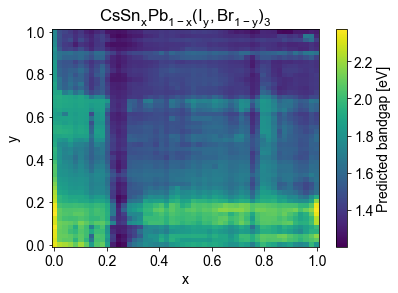

In [32]:
x_comp = np.linspace(0, 1.0, 50)
y_comp = np.linspace(0, 1.0, 50)
complist = [[f'CsSn{x}Pb{1-x}(I{y}Br{1-y})3' for x in x_comp] for y in y_comp]
val_df_list = [pd.DataFrame(({"formula": complist[x], "target": [0.0]*len(complist[0])})) for x in range(len(complist))]
print(len(val_df_list))
#val_df_x = pd.DataFrame(({"formula": complist[0], "target": [0.0]*len(complist[0])}))
#prediction, prediction_sigma = [cb_2.predict(val_df_list[x], return_uncertainty=True) for x in range(len(val_df_list))]
prediction_array = []
prediction_sigma_array = []
for x in range(len(val_df_list)):
    prediction, prediction_sigma = cb_eg_1.predict(val_df_list[x], return_uncertainty=True)
    prediction_array.append(prediction)
    prediction_sigma_array.append(prediction_sigma)
    


da = xr.DataArray(data=prediction_array,
                  coords={"x": (["x"], x_comp),
                          "y": (["y"], y_comp)},
                  dims=["y", "x"])
da.name = "Predicted bandgap"
da.attrs['units'] = 'eV'
da.plot()
plt.title('$\mathregular{CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$')

## Querying the archive for Sn, Pb based compounds


Let's query now for the solar cells in the existing database being part of the solid solution $CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}$. We will include all the quaternaries too. 

In [33]:
base_url = 'https://nomad-lab.eu/dev/rae/perovskite-database/api/v1'

Br_Cs_I_Pb_Sn_bandgaps =[]
Br_Cs_I_Pb_Sn_formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {"results.material.material_name:any": ["perovskite"],
              # "results.material.elements_exclusive": "Br Cs I Pb Sn",
              "results.material.n_elements": {
                "gte": 5,
                "lte": 5
              },
              "results.material.elements:all": ["Sn", 'Br', 'Cs', 'Pb', 'I'],
              # "results.material.elements:none": ["H"],
              # "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"]},
              # "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 1,
                   'page_after_value': page_after_value}
  }).json()

  # if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    elif 'band_gap' not in entry['archive']['results']['properties']['optoelectronic'].keys():
      continue
    else:
      Br_Cs_I_Pb_Sn_bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      Br_Cs_I_Pb_Sn_formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

In [34]:
base_url = 'https://nomad-lab.eu/dev/rae/perovskite-database/api/v1'

Cs_I_Pb_Sn_bandgaps =[]
Cs_I_Pb_Sn_formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {"results.material.material_name:any": ["perovskite"],
              # "results.material.elements_exclusive": "Br Cs I Pb Sn",
              "results.material.n_elements": {
                "gte": 4,
                "lte": 4
              },
              "results.material.elements:all": ["Sn", 'Cs', 'Pb', 'I'],
              # "results.material.elements:none": ["H"],
              # "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"]},
              # "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 1,
                   'page_after_value': page_after_value}
  }).json()

  # if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    elif 'band_gap' not in entry['archive']['results']['properties']['optoelectronic'].keys():
      continue
    else:
      Cs_I_Pb_Sn_bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      Cs_I_Pb_Sn_formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

In [35]:
base_url = 'https://nomad-lab.eu/dev/rae/perovskite-database/api/v1'

Cs_Br_Pb_Sn_bandgaps =[]
Cs_Br_Pb_Sn_formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {"results.material.material_name:any": ["perovskite"],
              # "results.material.elements_exclusive": "Br Cs I Pb Sn",
              "results.material.n_elements": {
                "gte": 4,
                "lte": 4
              },
              "results.material.elements:all": ["Sn", 'Cs', 'Pb', 'Br'],
              # "results.material.elements:none": ["H"],
              # "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"]},
              # "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 1,
                   'page_after_value': page_after_value}
  }).json()

  # if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    elif 'band_gap' not in entry['archive']['results']['properties']['optoelectronic'].keys():
      continue
    else:
      Cs_Br_Pb_Sn_bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      Cs_Br_Pb_Sn_formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

In [36]:
Cs_Br_Pb_Sn_formulas

[]

In [37]:
base_url = 'https://nomad-lab.eu/dev/rae/perovskite-database/api/v1'

Cs_Br_I_Pb_bandgaps =[]
Cs_Br_I_Pb_formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {"results.material.material_name:any": ["perovskite"],
              # "results.material.elements_exclusive": "Br Cs I Pb Sn",
              "results.material.n_elements": {
                "gte": 4,
                "lte": 4
              },
              "results.material.elements:all": [
                "Cs",
                "Pb",
                "I",
                "Br"
              ],
              # "results.material.elements:none": ["H"],
              # "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"]},
              # "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 1,
                   'page_after_value': page_after_value}
  }).json()

  # if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    elif 'band_gap' not in entry['archive']['results']['properties']['optoelectronic'].keys():
      continue
    else:
      Cs_Br_I_Pb_bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      Cs_Br_I_Pb_formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

In [38]:
base_url = 'https://nomad-lab.eu/dev/rae/perovskite-database/api/v1'

Cs_Br_I_Sn_bandgaps =[]
Cs_Br_I_Sn_formulas = []
page_after_value = None

while True:
  data = requests.post(f'{base_url}/entries/archive/query', headers={'Authorization': f'Bearer {token}'}, json={
    "owner": "visible",
    "aggregations": {},

    'query': {"results.material.material_name:any": ["perovskite"],
              # "results.material.elements_exclusive": "Br Cs I Pb Sn",
              "results.material.n_elements": {
                "gte": 4,
                "lte": 4
              },
              "results.material.elements:all": [
                "Cs",
                "Sn",
                "I",
                "Br"
              ],
              # "results.material.elements:none": ["H"],
              # "results.properties.available_properties:all": ["optoelectronic.band_gap"],
              "authors.name:any": ["Pepe Marquez"]},
              # "results.material.elements:all": ["Sn"]},

    'required': {# 'data':'*',
                'results':{
                    'material': {
                        'chemical_formula_reduced':'*'},
                    'properties': {
                        'optoelectronic':{
                            'band_gap':'*',
                            'solar_cell':{
                                'open_circuit_voltage':'*',
                                'short_circuit_current_density':'*',
                                'fill_factor':'*',
                                'efficiency':'*',
                                }}},},
                },
    'pagination': {'page_size': 1,
                   'page_after_value': page_after_value}
  }).json()

  # if len(data['data']) == 0:
  #  break
  if 'next_page_after_value' not in data['pagination'].keys():
    break
  page_after_value = data['pagination']['next_page_after_value']

  for entry in data['data']:
    if 'results' not in entry['archive'].keys():
      continue
    elif 'chemical_formula_reduced' not in entry['archive']['results']['material'].keys():
      continue
    elif 'band_gap' not in entry['archive']['results']['properties']['optoelectronic'].keys():
      continue
    else:
      Cs_Br_I_Sn_bandgaps.append(entry['archive']['results']['properties']['optoelectronic']['band_gap'][0]['value'])
      Cs_Br_I_Sn_formulas.append(entry['archive']['results']['material']['chemical_formula_reduced'])

## Let's place the formulas and bandgaps in a Pandas dataframe

In [39]:
formulas = []
for compo_list in [Br_Cs_I_Pb_Sn_formulas, Cs_I_Pb_Sn_formulas, Cs_Br_Pb_Sn_formulas, Cs_Br_I_Pb_formulas, Cs_Br_I_Sn_formulas]:
    formulas.append(compo_list)    
formulas = [item for sublist in formulas for item in sublist]

In [40]:
bandgaps = []
for bandgap_list in [Br_Cs_I_Pb_Sn_bandgaps, Cs_I_Pb_Sn_bandgaps, Cs_Br_Pb_Sn_bandgaps, Cs_Br_I_Pb_bandgaps, Cs_Br_I_Sn_bandgaps]:
    bandgaps.append(bandgap_list)    
bandgaps = [item for sublist in bandgaps for item in sublist]

In [41]:
Br_Cs_I_Pb_Sn_df = pd.DataFrame({'formula': formulas, 'bandgaps': bandgaps})
# Change the values of bandgap from units of Joule to electronvolt
Br_Cs_I_Pb_Sn_df['bandgaps'] = Br_Cs_I_Pb_Sn_df['bandgaps'] * 6.24150974e18
Br_Cs_I_Pb_Sn_df

,formula,bandgaps
0,Cs10Sn1Pb9I10Br20,1.79
1,Cs10Sn1Pb9I10Br20,1.79
2,Cs10Sn1Pb9I10Br20,1.79
3,Cs5Sn2Pb3I15,1.38
4,Cs5Sn2Pb3I15,1.38
...,...,...
452,Cs1Sn1I2Br1,1.37
453,Cs2Sn2I1Br5,2.36
454,Cs5Sn5I12Br3,1.40
455,Cs1Sn1I1Br2,1.63


In [42]:
def get_fractional_composition(formula):
    from pymatgen.core import Composition
    composition = Composition(formula)
    compo_dict = composition.as_dict()
    x = compo_dict['Sn']/(compo_dict['Sn']+compo_dict['Pb'])
    y = compo_dict['I']/(compo_dict['I']+compo_dict['Br'])
    return x, y

In [43]:
x_list = []
y_list = []
for formula in Br_Cs_I_Pb_Sn_df['formula']:
    x, y = get_fractional_composition(formula)
    x_list.append(x)
    y_list.append(y)

# print(x_list)
# print('')
# print(y_list)


In [44]:
Br_Cs_I_Pb_Sn_df['x'] = x_list
Br_Cs_I_Pb_Sn_df['y'] = y_list


In [45]:
appending_formulas = []

In [46]:

print(appending_formulas)
final_formulas = [ x for x in formulas if "H" not in x ]
# print(formulas)
# print(len(formulas))

[]


In [70]:
from matplotlib.pyplot import xlim


da = xr.DataArray(data=prediction_array,
                  coords={"x": (["x"], x_comp),
                          "y": (["y"], y_comp)},
                  dims=["y", "x"])
da.name = "Predicted bandgap"
da.attrs['units'] = 'eV'
# da.rolling(x=10, y=10, center=True).mean().plot(cmap='rainbow', vmin=1.2, vmax=2.3, xlim=(-0.05,1.05), ylim=(-0.05,1.05))
# da.plot(cmap='magma', vmin=1.2, vmax=2.3, xlim=(-0.05,1.05), ylim=(-0.05,1.05))
# plt.scatter(Br_Cs_I_Pb_Sn_df['x'], Br_Cs_I_Pb_Sn_df['y'], s=200, marker='o', facecolors='none', edgecolors='black')
# plt.title('$\mathregular{CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$')

Let's now plot the composition, bandgap value pairs that we have in the perovskite database (Figure a). Figure b shows the bandgap predicted for the whole compositional space of '${CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$'. The black  circles denote the compositions previously existing in the database (the one shown in figure a). 

Text(-0.15, 1.1, 'b')

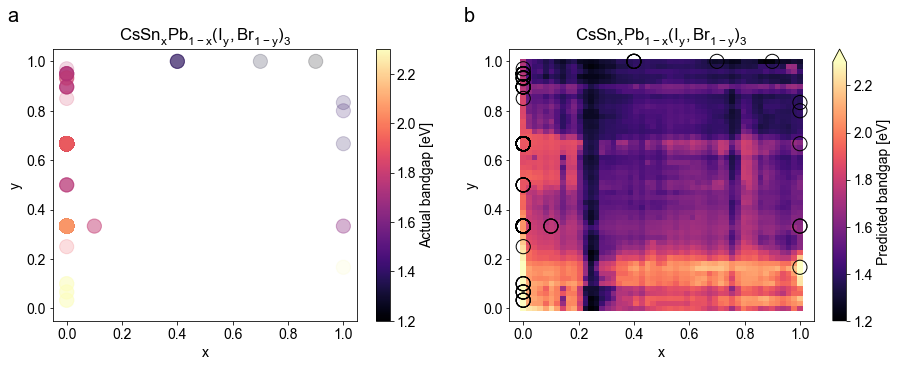

In [120]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].scatter(
    Br_Cs_I_Pb_Sn_df['x'], Br_Cs_I_Pb_Sn_df['y'], c=Br_Cs_I_Pb_Sn_df['bandgaps'], 
    s=200, alpha=0.2, cmap='magma',
    vmin=1.2, vmax=2.3)
    #set x axis label of axs[0] to be 'x'	

axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_ylim(-0.05,1.05)
axs[0].set_xlim(-0.05,1.05)
# show the color bar in axs[0]
cbar = fig.colorbar(axs[0].collections[0], ax=axs[0])
# cbar = axs[0].colorbar()
axs[0].set_title('$\mathregular{CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$')
cbar.set_label('Actual bandgap [eV]')
cbar.set_alpha(1)
cbar.draw_all()

# da.rolling(x=10, y=10, center=True).mean().plot(cmap='rainbow', vmin=1.2, vmax=2.3, xlim=(-0.05,1.05), ylim=(-0.05,1.05))
da.plot(cmap='magma', vmin=1.2, vmax=2.3, xlim=(-0.05,1.05), ylim=(-0.05,1.05), ax=axs[1])
plt.scatter(Br_Cs_I_Pb_Sn_df['x'], Br_Cs_I_Pb_Sn_df['y'], s=200, marker='o', facecolors='none', edgecolors='black')
plt.title('$\mathregular{CsSn_{x}Pb_{1-x}(I_{y},Br_{1-y})_{3}}$')
# add a label to axs[0] and b label to axs[1] figure of the plot  
axs[0].annotate('a', xy=(-0.15, 1.1), xycoords='axes fraction', fontsize=20)
axs[1].annotate('b', xy=(-0.15, 1.1), xycoords='axes fraction', fontsize=20)

## Quick bandgap prediction by inputing a formula

In [110]:
# a function that gets a formula as an input and returns the bandgap of the formula predicted by the model cb_eg_1
def get_bandgap():
    input_formula = input('Input a formula: ')
    #check if the imput formula is a valid pymatgen.core.compostion.Composition otherwise raise an error
    from pymatgen.core import Composition
    try:
        composition_check = Composition(input_formula)
        composition_check.valid
        df_get_bandgap = pd.DataFrame({'formula': [input_formula], 'target': [0.0]})
        prediction, prediction_sigma = cb_eg_1.predict(df_get_bandgap, return_uncertainty=True)
        #print the predicted bandgap with 3 decimal places and the uncertainty with 3 decimal places
        print(input_formula, 'predicted bandgap: {:.3f} +/- {:.3f} eV'.format(prediction[0], prediction_sigma[0]))
    except Exception:
        print(f'{input_formula} is an invalid formula')


In [117]:
get_bandgap()

Generating EDM: 100%|██████████| 1/1 [00:00<?, ?formulae/s]

loading data with up to 8 elements in the formula
CsSn1Pb0I3 predicted bandgap: 1.294 +/- 0.020 eV


## Checking to which compositions this is applicable

In general, for halide perovskites should work out ok wince this is the basis of the dataset used to train the model. 


In [69]:
saved_model = CrabNet()
saved_model.load_network(
    r'C:\Users\pepem\Perovskite_database\models\trained_models\Perovskite_eg_1.pth')


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


AssertionError: 

In [117]:

for formula in formulas:
    if 'H' not in formula:
        print(formula) 
from pymatgen.core import Composition
composition = Composition(formulas[1])
compo_dict = composition.as_dict()
print(compo_dict['Sn']/(compo_dict['Sn']+compo_dict['Pb']))

# composition.get_atomic_fraction('Pb')

Cs2Sn1Pb1I2Br4
Cs10Sn1Pb9I10Br20
Cs2Sn1Pb1I4Br2
Cs4Sn3Pb1I4Br8
Cs10Sn1Pb9I10Br20
Cs10Sn1Pb9I10Br20
Cs2Sn1Pb1I4Br2
Cs2Sn1Pb1I4Br2
Cs4Sn1Pb3I4Br8
0.1


In [176]:
final_formulas = [ x for x in df_grouped_formula['formula'] if "H" not in x ]
print(len(final_formulas))
Pb_Sn_final_formulas = [ x for x in final_formulas if "Cs" in x and "Pb" in x and 'Sn' in x and "I" in x]
print(len(Pb_Sn_final_formulas))

print(final_formulas)

92
4
['Cs10Sn1Pb9I10Br20', 'Cs10Sn7Pb3I30', 'Cs10Sn9Pb1I30', 'Cs5Sn2Pb3I15']


For training the model before we have used the default table for featurizing our composition which is Mat2Vec

In [45]:
from crabnet.utils.composition import generate_features
df_features_oinynyk = generate_features(df_grouped_formula, elem_prop='oliynyk', drop_duplicates=False, extend_features=False, sum_feat=False, mini=False)

Processing Input Data: 100%|██████████| 860/860 [00:00<00:00, 15933.55it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 860/860 [00:00<00:00, 8081.11it/s]


	Creating Pandas Objects...


In [49]:
df_features_oinynyk

(     avg_Number  avg_Atomic_Weight  avg_Period  avg_group  avg_families  \
 0     57.000000         137.411075    5.166667  15.666667      6.833333   
 1     58.400000         141.416023    5.200000  16.000000      7.000000   
 2     55.250000         132.404890    5.125000  15.250000      6.625000   
 3     60.041416         146.137333    5.237117  16.453683      7.240594   
 4     54.200000         129.401179    5.100000  15.000000      6.500000   
 ..          ...                ...         ...        ...           ...   
 855   19.800000          46.502983    2.525000   8.333333      7.083333   
 856   20.132743          46.684377    2.725664  11.672566      7.088496   
 857   21.483333          51.166649    2.579167   8.283333      7.070833   
 858   20.933333          49.671899    2.566667   8.133333      7.033333   
 859   21.300000          50.668399    2.575000   8.233333      7.058333   
 
      avg_Metal  avg_Nonmetal  avg_Metalliod  avg_Mendeleev_Number  \
 0     0.333333 